In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.filters import gaussian, threshold_otsu
from skimage.color import rgb2gray
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
def preprocess_images(folder_path, label):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            image = imread(os.path.join(folder_path, file))
            gray_image = rgb2gray(image)
            blurred_image = gaussian(gray_image, sigma=0.7)
            otsu_threshold = threshold_otsu(blurred_image)
            binary_image = blurred_image < otsu_threshold
            resized_image = resize(binary_image, (128, 128))
            images.append(resized_image)
            labels.append(label)
    return images, labels


In [3]:
dataset_paths = {
    "Normal": "images/Normal(284x12=3408)",
    "Abnormal": "images/Abnormal heartbeat (233x12=2796)",
    "MI": "images/Myocardial Infarction(240x12=2880)",
    "History_MI": "images/History of MI (172x12=2064)",
}

In [4]:
# Step 3: Load Data
all_images = []
all_labels = []

for label, folder in dataset_paths.items():
    images, labels = preprocess_images(folder, label)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert to NumPy arrays
X = np.array(all_images).reshape(-1, 128, 128, 1)  # Add channel dimension for CNN
y = np.array(all_labels)

In [5]:
# Step 4: Encode Labels and Split Data
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [6]:
# Step 5: Build CNN Model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# Step 6: Train the Model
input_shape = (128, 128, 1)  # Image size with one channel (grayscale)
num_classes = y_categorical.shape[1]

cnn_model = build_cnn(input_shape, num_classes)
cnn_model.summary()

history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

C:\Users\thala\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.2507 - loss: 1.4492 - val_accuracy: 0.3333 - val_loss: 1.3532
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.3632 - loss: 1.3319 - val_accuracy: 0.4946 - val_loss: 1.1817
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.5174 - loss: 1.1392 - val_accuracy: 0.6720 - val_loss: 1.0021
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.6364 - loss: 0.9080 - val_accuracy: 0.7258 - val_loss: 0.7538
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.7438 - loss: 0.6791 - val_accuracy: 0.6828 - val_loss: 0.7790
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.8060 - loss: 0.5644 - val_accuracy: 0.8441 - val_loss: 0.4458
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8755 - loss: 0.3749 - val_accuracy: 0.8602 - val_loss: 0.3986
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.9083 - loss: 0.2936 - val_accuracy: 0.

In [8]:
# Step 7: Evaluate the Model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 8: Save the Model
cnn_model.save("ecg_cnn_model.h5")
print("Model saved as ecg_cnn_model.h5")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9411 - loss: 0.2045


Test Accuracy: 0.91
Model saved as ecg_cnn_model.h5


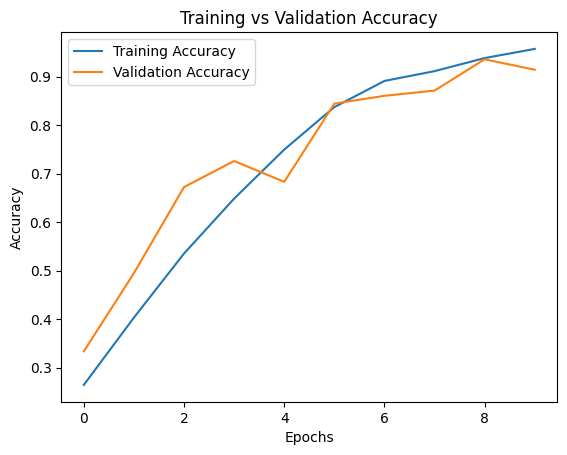

In [9]:
# Step 9: Visualize Training Performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [10]:
import tensorflow as tf
import pickle

In [11]:
model = tf.keras.models.load_model('ecg_cnn_model.h5')

In [12]:
# Step 2: Save the model as a .pkl file
with open('ecg_cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model has been saved as ecg_cnn_model.pkl")

Model has been saved as ecg_cnn_model.pkl


In [13]:
import pickle

In [14]:
# Step 1: Load the .pkl file
with open('ecg_cnn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

C:\Users\thala\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Step 2: Use the model for predictions
import numpy as np
# Example input: Random tensor simulating an image of shape (128, 128, 1)
sample_input = np.random.rand(1, 128, 128, 1)
prediction = loaded_model.predict(sample_input)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction: [[1.0000000e+00 4.8363963e-19 7.2047992e-14 3.9937467e-18]]


In [16]:
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

In [20]:
# Load your saved model and encoder
model = load_model('ecg_cnn_model.h5')  

In [22]:
def preprocess_custom_image(image_path):
    # Load and preprocess EXACTLY like training data
    image = imread(image_path)
    
    # Convert to grayscale
    if len(image.shape) == 3:  # Color image
        gray_image = rgb2gray(image)
    else:  # Already grayscale
        gray_image = image
    
    # Apply preprocessing pipeline
    blurred_image = gaussian(gray_image, sigma=0.7)  # Fix indentation here
    otsu_threshold = threshold_otsu(blurred_image)
    binary_image = blurred_image < otsu_threshold  # Important: Same thresholding direction!
    resized_image = resize(binary_image, (128, 128))
    
    # Add channel dimension and batch dimension
    processed_image = resized_image.reshape(1, 128, 128, 1)  # (batch, height, width, channels)
    return processed_image

In [23]:
# Path to your test image
test_image_path = "Normal/Normal(1).jpg"  # Replace with your image path


In [24]:
# Check if file exists
if not os.path.exists(test_image_path):
    print(f"Error: File not found at {test_image_path}")
else:
    # Preprocess the image
    processed_image = preprocess_custom_image(test_image_path)
    
    # Make prediction
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)
    
    # Inverse transform using your original LabelEncoder (must be available)
    try:
        predicted_label = encoder.inverse_transform(predicted_class_index)[0]
    except NameError:
        print("LabelEncoder not found! Make sure to load/save it with pickle.")
        predicted_label = predicted_class_index[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


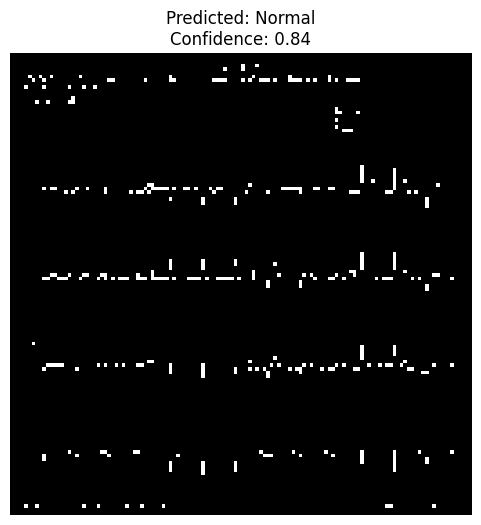

In [26]:
# Display results
plt.figure(figsize=(6, 6))
plt.imshow(processed_image.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_label}\nConfidence: {np.max(prediction):.2f}")
plt.axis('off')
plt.show()


In [29]:
# Print detailed probabilities
print("Prediction probabilities:")
for i, class_prob in enumerate(prediction[0]):
    print(f"{encoder.classes_[i]}: {class_prob:.4f}")


Prediction probabilities:
Abnormal: 0.1509
History_MI: 0.0069
MI: 0.0001
Normal: 0.8420
